In [1]:
# !pip3 install --user torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
# !pip3 install torch==1.11.0+cu113 torchvision==0.12.0+cu113 torchaudio==0.11.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
# !pip3 install rich numpy matplotlib

# !pip3 install nms scikit-image

# !pip3 install jupyter-tensorboard

# !pip3 install "opencv-python-headless<4.3"

# !pip install ipywidgets
# !pip install nms

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import matplotlib.patches as patches
sys.path.append("..")

from Models.splinedist import *
import pytorch_lightning as pl
import torch
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint, LearningRateMonitor, RichProgressBar, RichModelSummary
from Datasets.CISD import * 

In [3]:

logger = pl_loggers.TensorBoardLogger(
    save_dir=os.path.join(os.getcwd(), "pl_logs_final2"),
    name="spline_dist/CISD",
    log_graph=True,
    default_hp_metric=True)

checkpoint_callback = ModelCheckpoint(
    monitor="loss_val",
    dirpath="Models_final2/weights",
    filename="splineDist-CISD-{epoch:02d}-{loss_val:.2f}",
    save_top_k=2,
    mode="min",
)

earlystoping_callback = EarlyStopping("loss_val")

lr_logger = LearningRateMonitor(logging_interval="step")
summary = RichModelSummary(max_depth=-1)
progressbar = RichProgressBar()

callbacks = [progressbar, checkpoint_callback, lr_logger] 



In [4]:
model = SplineDist(lambda1=0.9, lambda2=1e-4, learning_rate=1e-4, num_control_points=64, object_threshold=0.5, kernel_size=3, contourSize=500, device="cuda:0",nms_threshold=0.1)

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


0.9838585


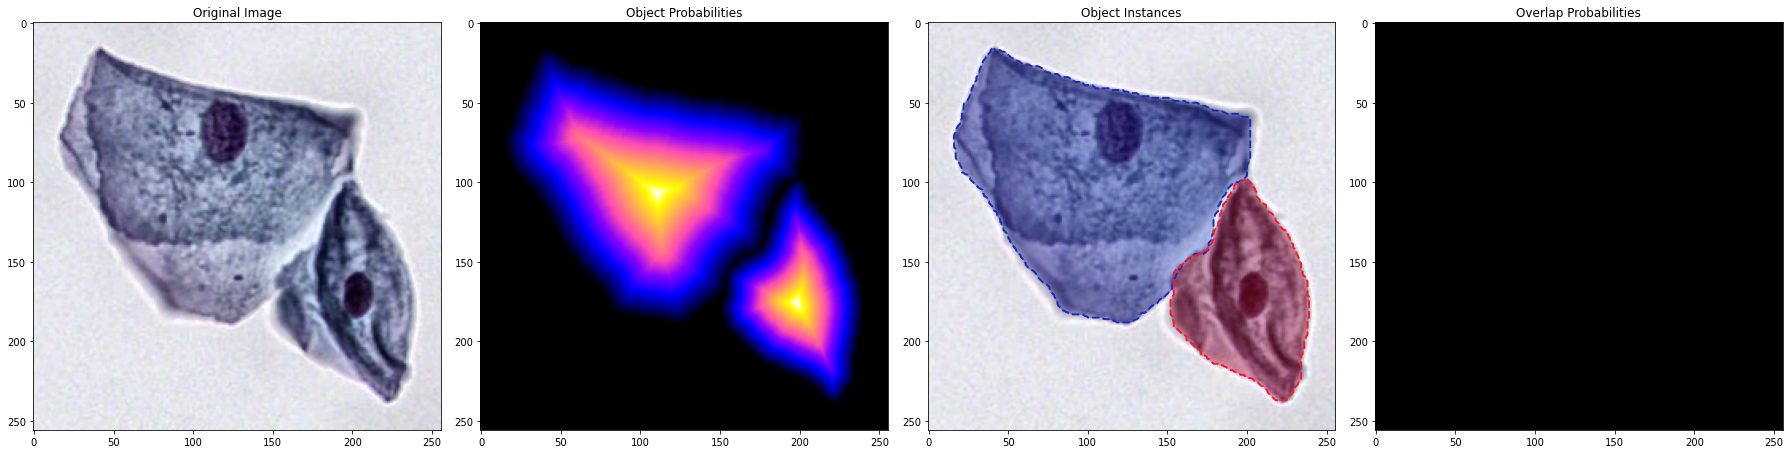

0.96117467


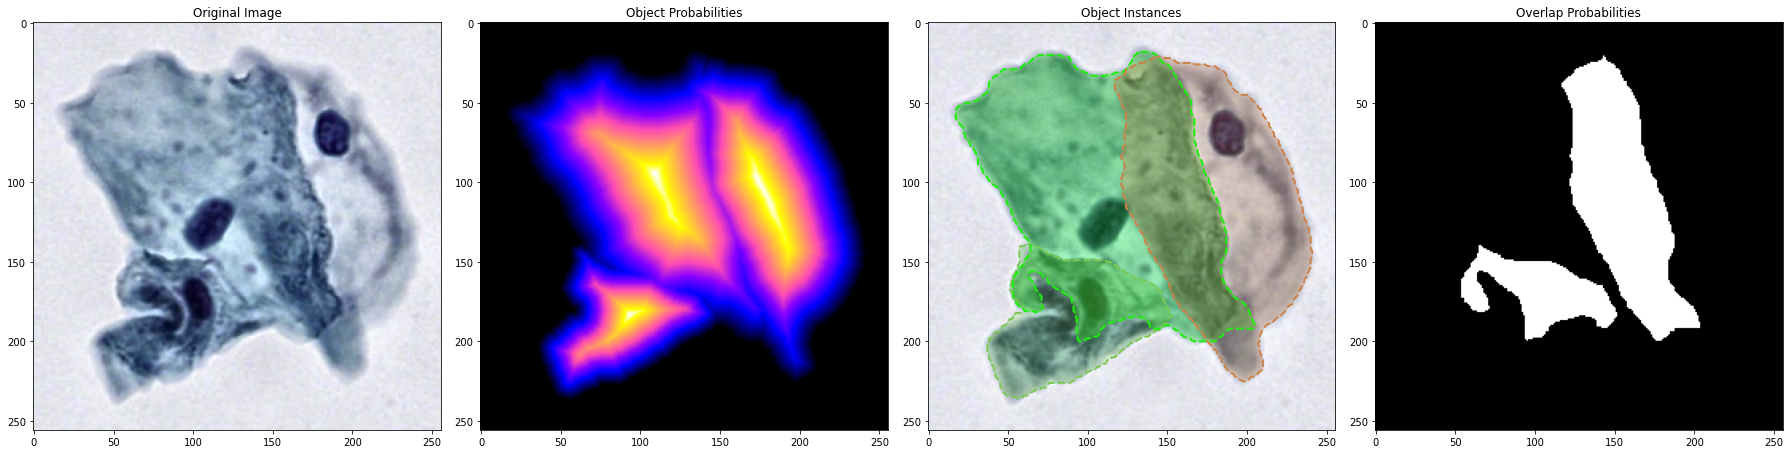

0.9688014


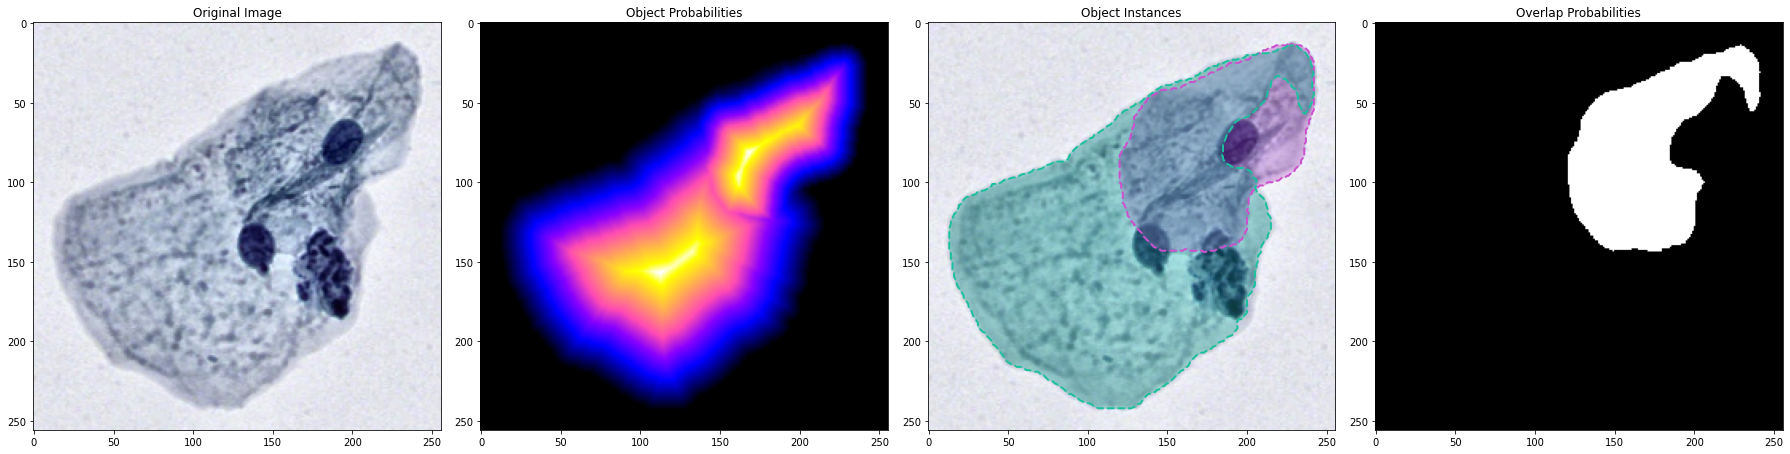

0.9271205


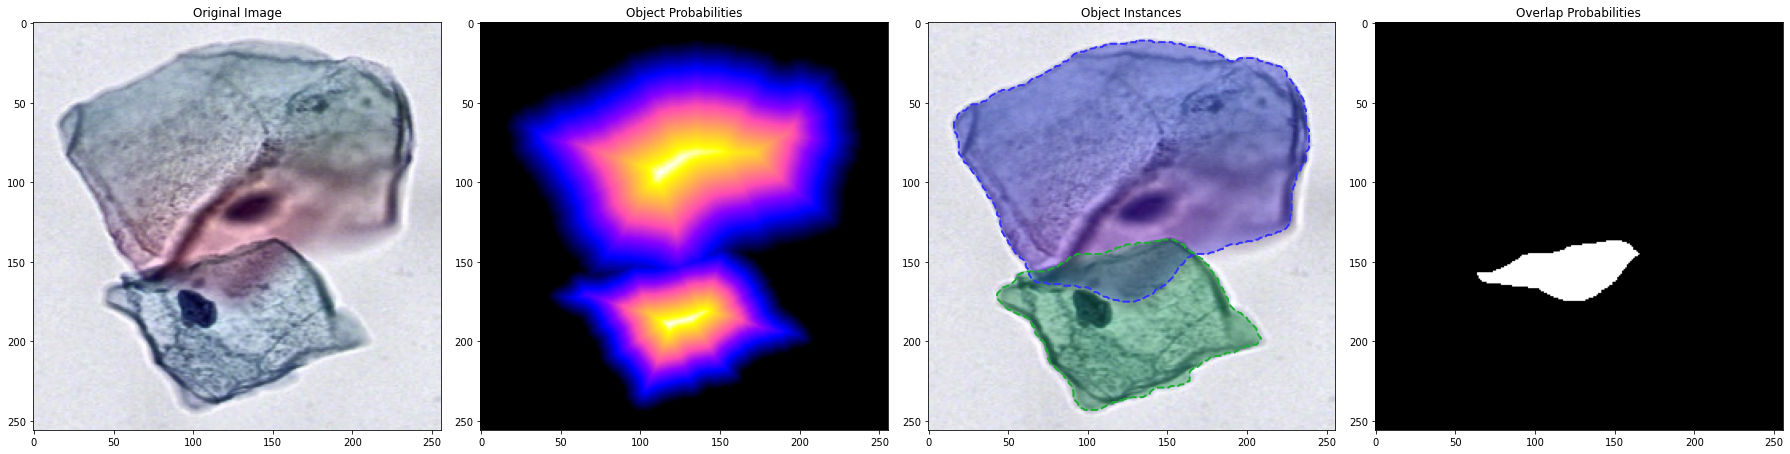

0.98085445


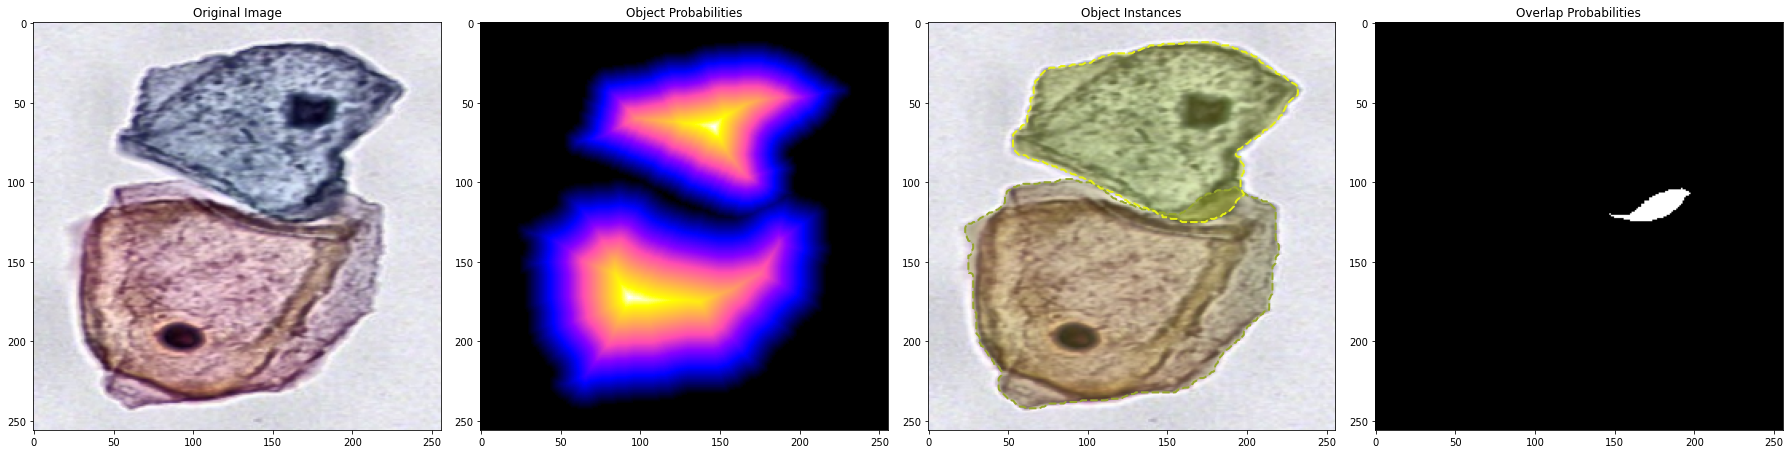

0.9670241


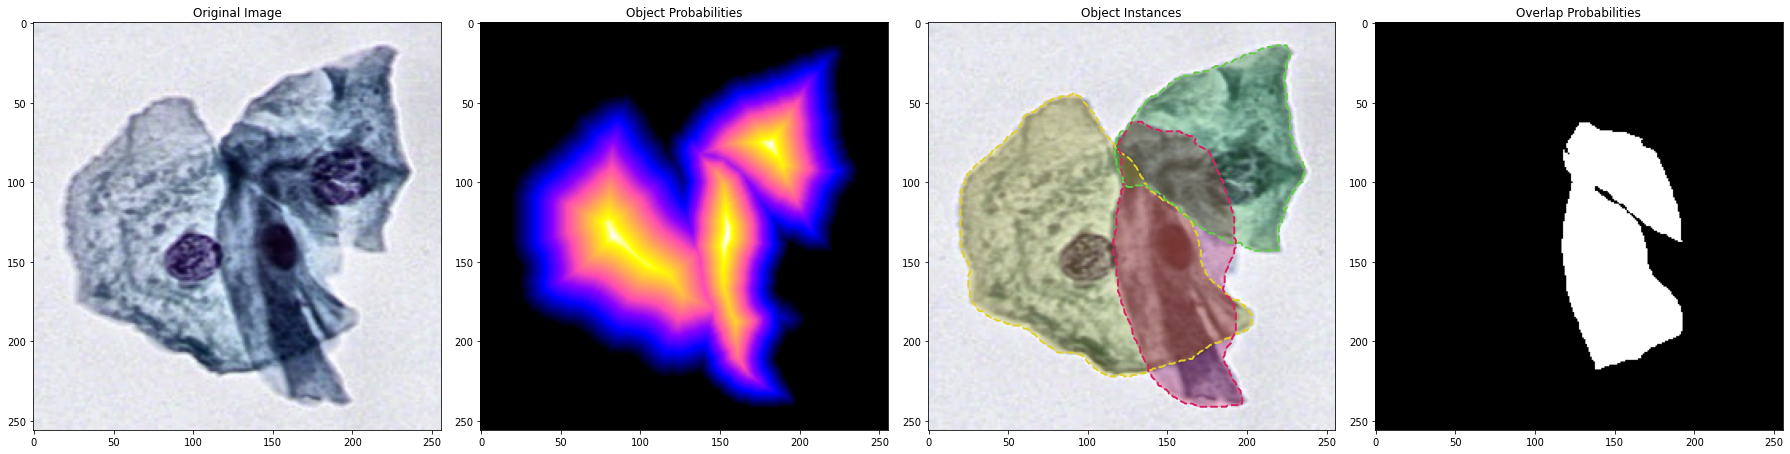

0.9766698


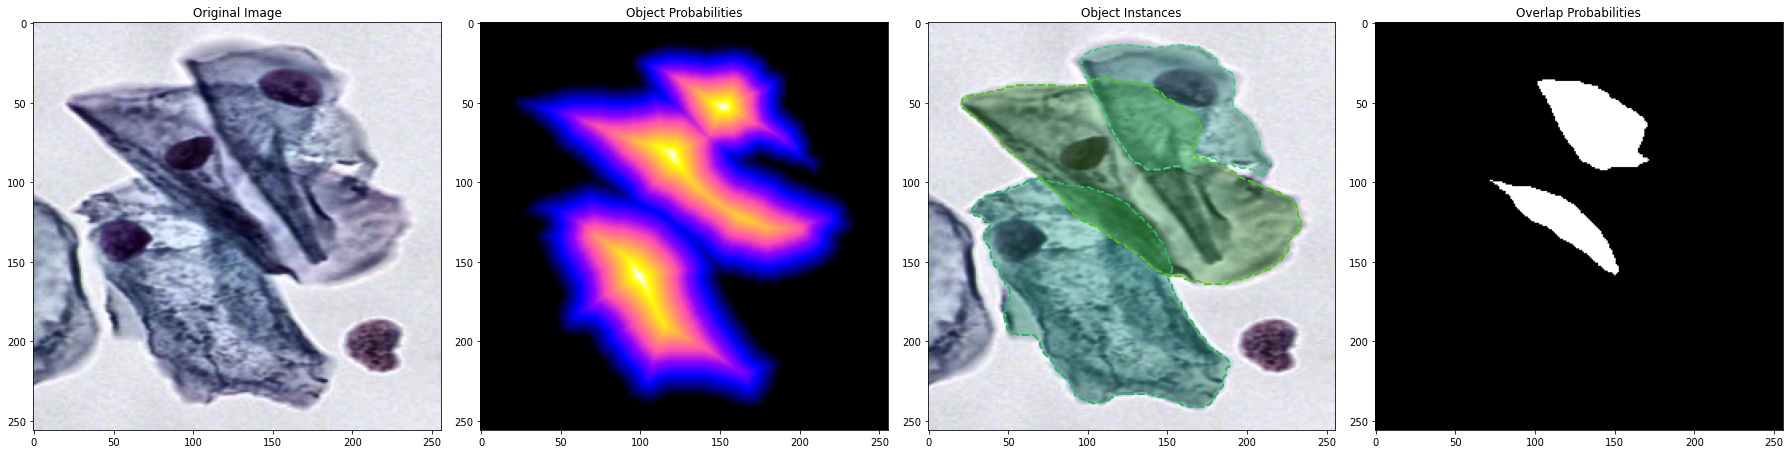

0.9714155


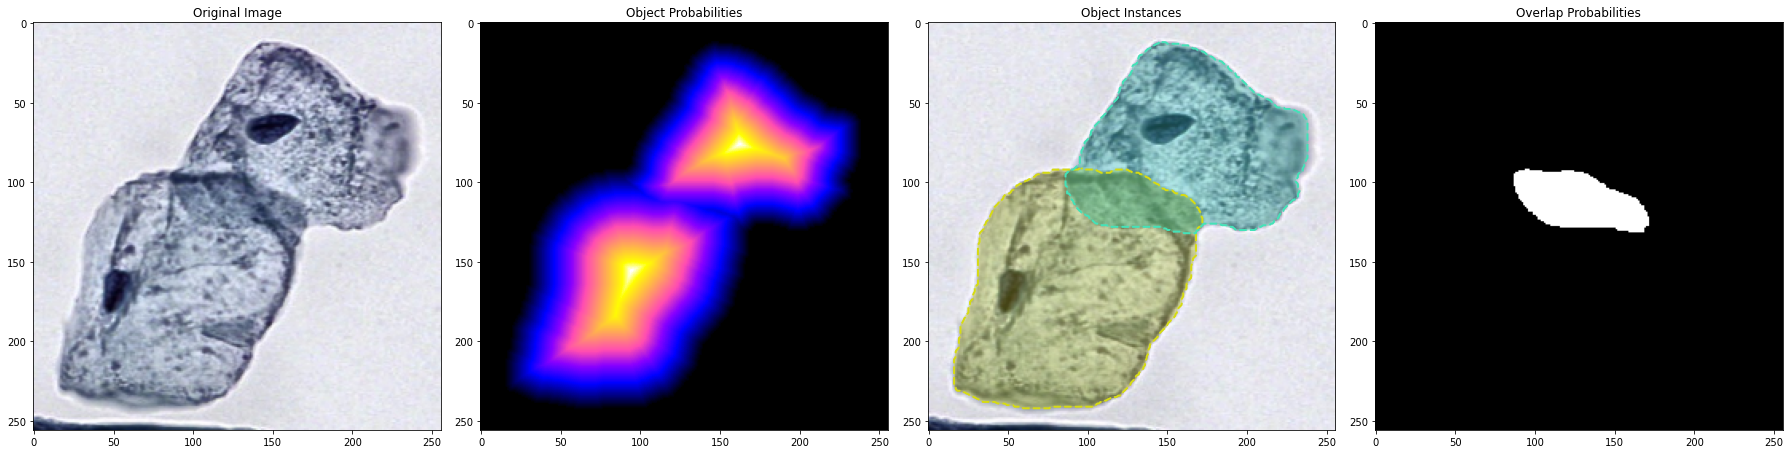

In [5]:
# pl.seed_everything(47)
data = CISD_datamodule(contourSize=500)
batch_x, batch_y = next(iter(data.val_dataloader()))
showBatch((batch_x, batch_y))
# data = Nuclie_data(os.path.join(os.getcwd(), "src", "Datasets", "DSB18", "train"))
# for(img, target) in data:
#     print(img.shape)
#     # plt.imshow(img[0])
    

In [6]:
# from torchvision import io 
# for mask in os.listdir("C:\\SplineDist\\src\Datasets\\DSB18\\train\\00071198d059ba7f5914a526d124d28e6d010c92466da21d4a04cd5413362552\\masks/"):
#     io.read_image(mask)

In [7]:
torch.cuda.empty_cache()
trainer = pl.Trainer(max_epochs=400,
                     gpus=[0],
                     callbacks=callbacks,
                     logger=logger,
                     num_sanity_val_steps=0)
trainer.fit(model, data)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/_jit_internal.py:668: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  if hasattr(mod, name):
/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/master/home/mbenimam/SplineDist/src/Experiments/../Models/unet.py:62: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode=

┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃   ┃ Name                           ┃ Type         ┃ Params ┃      In sizes ┃    Out sizes ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ 0 │ rgb2gray                       │ Conv2d       │      4 │   [1, 3, 256, │  [1, 1, 256, │
│   │                                │              │        │          256] │         256] │
│ 1 │ segmentationBackbone           │ UNet         │ 17.3 M │   [1, 1, 256, │     [1, 128, │
│   │                                │              │        │          256] │    256, 256] │
│ 2 │ objectFinder                   │ Conv2d       │  1.2 K │ [1, 128, 256, │  [1, 1, 256, │
│   │                                │              │        │          256] │         256] │
│ 3 │ objectOverlap                  │ Conv2d       │  1.2 K │ [1, 128, 256, │  [1, 1, 256, │
│   │                                │              │        │          256] │         256] │
│ 4 │ ControlPointsAngleRegressor    │ Conv2d       │ 73.8 K │ [1, 128, 256, │ [1, 64, 256, │
│   │                                │              │        │          256] │         256] │
│ 5 │ ControlPointsDistanceRegressor │ Conv2d       │ 73.8 K │ [1, 128, 256, │ [1, 64, 256, │
│   │                                │              │        │          256] │         256] │
│ 6 │ cos                            │ Cos          │      0 │  [1, 64, 256, │ [1, 64, 256, │
│   │                                │              │        │          256] │         256] │
│ 7 │ sin                            │ Sin          │      0 │  [1, 64, 256, │ [1, 64, 256, │
│   │                                │              │        │          256] │         256] │
│ 8 │ bce                            │ BCEWithLogi… │      0 │             ? │            ? │
└───┴────────────────────────────────┴──────────────┴────────┴───────────────┴──────────────┘

Trainable params: 17.5 M                                                                     
Non-trainable params: 0                                                                      
Total params: 17.5 M                                                                         
Total estimated model params size (MB): 69

Output()

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /master/home/mbenimam/SplineDist/src/Experiments/Models_final2/weights exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/nn/functional.py:1795: 
UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")

RuntimeError: Caught RuntimeError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/utils/data/_utils/worker.py", line 287, in _worker_loop
    data = fetcher.fetch(index)
  File "/master/home/mbenimam/.local/lib/python3.8/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    return self.collate_fn(data)
  File "/usr/local/lib/python3.8/dist-packages/pytorch_lightning/utilities/auto_restart.py", line 474, in _capture_metadata_collate
    data = default_collate(samples)
  File "/master/home/mbenimam/SplineDist/src/Experiments/../Datasets/CISD.py", line 258, in collate_fn
    objectContours = torch.stack(objectContours, dim=0)
RuntimeError: [enforce fail at CPUAllocator.cpp:68] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 2097152000 bytes. Error code 12 (Cannot allocate memory)
